# Week 1

First just try the Gillespie Algorithm:

Text(0, 0.5, '# Infected')

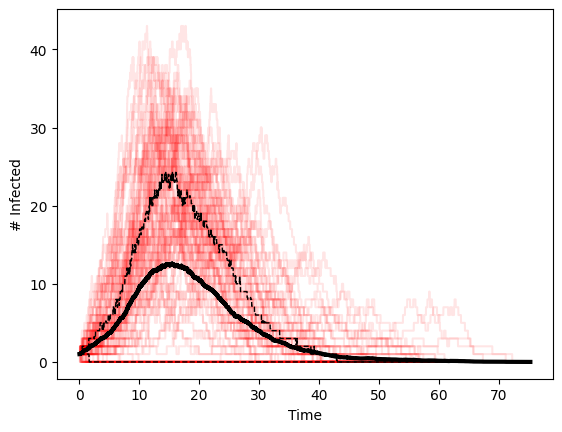

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

from bp_models.gillespie import direct_gillespie

Number_of_sims = 100
N = 100
beta = 0.5
mu = 0.2

fig, ax = plt.subplots()

ts = []
Is = []
S_finals = []
max_t = 0

for _ in range(Number_of_sims):
    t, I, S_final = direct_gillespie(N, beta, mu)
    
    ts.append(t)
    Is.append(I)
    S_finals.append(S_final)
    
    if t[-1] > max_t:
        max_t = t[-1]

plot_t = np.linspace(0, max_t, num=int(max_t)*1000)
padded_data = []
for t, s in zip(ts, Is):
    padded = interp1d(t, s, bounds_error=False, fill_value=0, kind='nearest')(plot_t)
    ax.plot(plot_t, padded, 'r', alpha=0.1)
    padded_data.append(padded)

padded_data = np.asarray(padded_data)
ax.plot(plot_t, padded_data.mean(axis=0), 'k', linewidth=3)
ax.plot(plot_t, np.quantile(padded_data, 0.25, axis=0), 'k--', linewidth=1)
ax.plot(plot_t, np.quantile(padded_data, 0.75, axis=0), 'k--', linewidth=1)

ax.set_xlabel("Time")
ax.set_ylabel("# Infected")

Next plot a histogram of the total number of infected, noting that this is given by the $N$ minus the remaining number of susceptible at the end simulation.

Text(0.5, 0, 'Total number of infections')

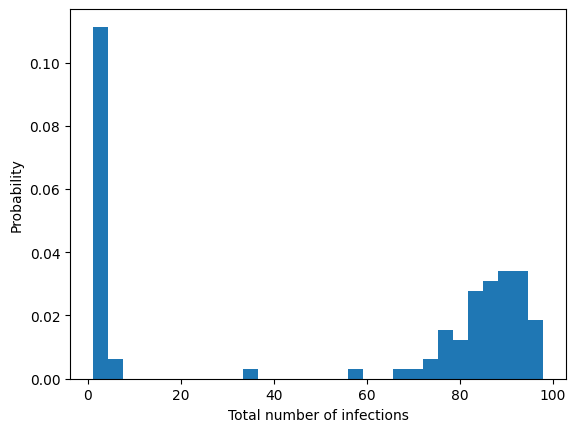

In [23]:
fig, ax = plt.subplots()
S_finals = np.asarray(S_finals)

total_infected = N -S_finals

ax.hist(total_infected, bins=30, density=True)
ax.set_ylabel("Probability")
ax.set_xlabel("Total number of infections")

From this we see the definition of a major outbreak is not super important e.g. 20% or 40% of the population infected would make not practical difference. For now we use 20% and calculated the proportion of major outbreaks.

In [12]:
print(f"Proportion of major outbreaks: {np.sum(total_infected/N > 0.2)/Number_of_sims}")

Proportion of major outbreaks: 0.63


# Analytical approaches to estimating the probability of an outbreak
## Method 1: Probability generating functions

The offspring distribution is the probability that an infected individual generates $k$ new infections and is denoted $\mathbb{P}(X=k)$. The for any model $R_0 = \sum_{k=0}^\infty k\mathbb{P}(X=k)$. The early outbreak can then be approximated as a branching process.

For an discrete random variable $X$, the probability generating function (PGF) is given by
$$
\begin{equation*}
    G_X(z) = \mathbb{E}[z^X] = \sum_{k=0}^\infty z^k\mathbb{P}(X=k).
\end{equation*}
$$

Instead it can be more straightforward to calculate the probability that a major outbreak does not occur. The probability a major outbreak does not occur from a single infection is given by $q$. For a major outbreak to fail we need either:
- first individual to infect nobody,
- all individuals infected by the first person to infect nobody.
This can be expressed as
$$
\begin{equation*}
\mathbb{P}(\text{no major outbreak}) =\mathbb{P}(\text{first individual infects nobody}) + \sum_{k=1}^\infty (\mathbb{P}(\text{first individual infects $k$ others}) \cdot \mathbb{P}(\text{k infected don't cause major outbreak})),
\end{equation*}
$$
or in terms of the PGF
$$
\begin{equation*}
q = \sum_{k=0}^\infty q^k\mathbb{P}(X=k) = G_X(q).
\end{equation*}
$$
Hence, the $q$ is given by the smallest non-negative solution of $G_X(q)=q$. Once $q$ is calculated, either analytically or numerically, the probability that a major outbreak occurs from a single individual is given be $p=1-q$.

Under the assumption that $S(t)\approx N$, for our SIR model we have
$$
\begin{equation*}
\mathbb{P}(X=k)=\frac{R_0^k}{(R_0+1)^{k+1}},
\end{equation*}
$$
which is a geometric distribution with "success probability" $1/(R_0+1)$. The PGF of a geometric distribution is
$$
\begin{equation*}
G_X(z) = \frac{s}{1-(1-s)z}.
\end{equation*}
$$
Hence, the equation $G_X(q)=q$ yields
$$
\begin{equation*}
R_0q^2 - (R_0 +1)q +1=0,
\end{equation*}
$$
The solutions of which are $q=1$ and $q=1/R_0$ and therefore $p = 1 - 1/R_0$.

In [25]:
R0 = beta/mu
print(f"Theoretical probability of a major outbreak: {1 - 1/R0}")
print(f"Double checking numerically: {1 - np.roots([R0, -(R0+1), 1])}")

Theoretical probability of a major outbreak: 0.6
Double checking numerically: [2.22044605e-16 6.00000000e-01]


## First-step analysis

We denote the probability that an major outbreak fails to develop from $i$ infected individuals by $q_i$. By a branching process assumption we have that $q_m=q_1^m$.

From a single infection, the law of total probability gives
$$
\begin{align*}
\mathbb{P}(\text{no major outbreak}) =& \mathbb{P}(\text{no major outbreak}|\text{first event is infection})\cdot\mathbb{P}(\text{first event is infection})\\
&+\mathbb{P}(\text{no major outbreak}|\text{first event is removal})\cdot\mathbb{P}(\text{first event is removal}).
\end{align*}
$$
We have that the probability the first event is an infection as $\beta/(\beta+\gamma)$ and the probability that the first event is a removal is $\gamma/(\beta+\gamma)$. This gives
$$
\begin{equation*}
q_1 = \frac{\beta}{\beta+\gamma}q_2 + \frac{\gamma}{\beta+\gamma}q_0.
\end{equation*}
$$
Finally, applying the branching process assumption and noting that $q_0=1$ we have
$$
\begin{equation*}
q_1 = \frac{\beta}{\beta+\gamma}q_1^2 + \frac{\gamma}{\beta+\gamma}.
\end{equation*}
$$
This has the same roots and thus the same probability of a major outbreak as the PGF method.